In [40]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append('..')
sys.path.append('../src')
import os
from os.path import join as oj
import numpy as np
from copy import deepcopy
import pandas as pd
import data
# import models
from math import ceil
# from style import *
import dvu
import pickle as pkl
from tqdm import tqdm
# from style import *
import neural_networks
import viz
from viz import *
import config
import outcomes
outcome_def = 'successful_full_final'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# setup defn

In [3]:
# load model
dfs, feat_names = data.load_dfs_for_lstm(dsets=['clath_aux_dynamin'], splits=['train', 'test'],
                                         meta=['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized'], normalize=False)

100%|██████████| 1/1 [02:16<00:00, 136.61s/it]


In [4]:
df = pd.concat([dfs[(k, s)] for (k, s) in dfs])

In [38]:
# df = data.get_data(use_processed=True) #, dset='orig') # all_data=True
# df = data.get_data(dset='clath_aux_dynamin')
df = outcomes.add_aux_dyn_outcome(df)
df = df[~df['hotspots']]
# dfv = df[df['valid'] == 1] # exclude test cells, short/long tracks, hotspots

p = 1
results = pkl.load(open(config.FINAL_MODEL, 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

<All keys matched successfully>

In [39]:
df['preds'] = dnn.predict(df[feat_names[:1]])
df = df.sort_values(by='preds')
x = df[feat_names[:1]]
y = df[outcome_def].values
preds = dnn.predict(x)
n = df.shape[0]

# viz errs

In [ ]:
# for figure
y = df[outcome_def].astype(bool)
p = df['preds'].values > 0

tp = y & p
tn = ~y & ~p
fp = ~y & p
fn = y & ~p

ks = {
    'fp': fp,    
#     'tp': tp,
#     'tn': tn,
#     'fn': fn
}
print('tp', tp.sum(), 'tn', tn.sum(), 'fp', fp.sum(), 'fn', fn.sum())


for k in ks:
    idxs = ks[k]
    num_tot = idxs.sum()
    print(k, idxs.sum())

    R = 5
    C = 10
    MULT = R * C
    for fig_num in tqdm(range(num_tot // MULT)):
        

        fig = plt.figure(figsize=(C * 3, R * 2.5), facecolor='w')
        d = df[idxs].iloc[fig_num * MULT: (fig_num + 1) * MULT]

        if k == 'fn':
            clathmax = 3500
            auxmax = 2000
        else:
            clathmax = 16000
            auxmax = 3500
    
        viz.plot_curves(d, R=R, C=C, hline=False,
                xlim_constant=True,
                ylim_constant=True,
                legend=True,
                extra_key='Z_extended',
                extra_key_label='Dynamin',
                #xlim=(0, 55),
                ylim_cla=(-500, clathmax),
                ylim_aux=(-500, auxmax),
                ylim_dyn=(-500, auxmax),
                yticks=[0, 2000],
                background=True,
                show_track_pid=True,
                #yticklabels=["$0$", "$10^4$"],                
                fig=fig
        )


        plt.savefig(f'{k}_{fig_num}.pdf')
#         plt.show()
        fig.clear()
        plt.close(fig)

# save out ids

In [8]:
for k in ks:
    ids = df[ks[k]].pid
    np.savetxt(k + '.csv', ids, fmt='%d', delimiter=',')

# saving

In [ ]:
!zip labeling.zip *.csv *.pdf

# labs_to_flip

In [34]:
fp1 = pd.read_csv('fp.csv', header=None)
fp2 = pd.read_csv('fp_2.csv', header=None)
fn_flipped = pd.read_csv('fn_flipped.csv', header=None)
fn2 = pd.read_csv('fn2.csv', header=None)


HOTSPOTS = []
for e in [fp1, fp2, fn_flipped]:
    pids = e[e[1]=='h'][0].values
    HOTSPOTS.append(pids)
    pids = e[e[1]=='p'][0].values
    HOTSPOTS.append(pids)
HOTSPOTS = np.hstack(HOTSPOTS)

POS = []
for e in [fp1, fp2]:
    pids = e[e[1]=='x'][0].values
    POS.append(pids)
    pids = e[e[1]=='s'][0].values
    POS.append(pids)
POS = np.hstack(POS)

NEG = []
# for e in [fn2]:
#     pids = e[e[1]=='x'][0].values
#     NEG.append(pids)
for e in [fn_flipped]:
    pids = e[e[1].isna()][0].values
    NEG.append(pids)
NEG = np.hstack(NEG)

In [35]:
print(HOTSPOTS.tolist())

[172868, 77374, 164533, 173308, 76013, 214830, 115275, 86766, 176277, 139509, 218580, 97279, 130184, 83200, 244850, 176241, 243233, 108341, 147163, 191970, 168032, 76785, 180315, 147732, 94289, 153579, 224739, 244326, 108770, 103430, 183172, 185366, 112627, 191468, 76164, 242576, 126272, 147430, 124255, 175312, 137799, 147237, 173860, 186038, 147764, 124678, 146161, 74685, 216992, 93914, 92189, 218179, 182612, 123187, 96054, 243671, 223192, 97534, 216832, 181858, 117229, 165534, 79522, 186204, 148968, 194481, 95770, 232757, 136997, 192046, 69346, 125579, 181534, 130633, 147538, 75868, 187927, 244127, 254203, 92488, 103684, 162291, 75118, 96993, 146527, 154818, 184729, 68905, 255364, 150068, 84924, 125150, 166460, 132829, 187010, 183607, 78896, 255814, 96870, 246264, 181464, 249701, 249161, 107385, 107287, 148087, 183597, 154229, 152942, 186369, 191563, 178048, 173433, 190905, 85832, 165772, 98544, 182742, 140938, 164643, 212316, 106303, 205390, 185324, 209675, 149368, 152904, 76422, 24

In [36]:
print(POS.tolist())

[142117, 144527, 225634, 97901, 249850, 236228, 233588, 125715, 96242, 158505, 257382, 127169, 133540, 118404, 134882, 123899, 135231, 97213, 138249, 84243, 176592, 104323, 225498, 131338, 209033, 148040, 126268, 218314, 75956, 123548, 77685, 133283, 148798, 172630, 194904, 109032, 164976, 190867, 147479, 209511, 122980, 113164, 121481, 125555, 122018, 213648, 121256, 76555, 132973, 245669, 121388, 190718, 122979, 123685, 124759, 109580, 78776, 183782, 252108, 126438, 121651, 126768, 244340, 125063, 92061, 94819, 174116, 245280, 195507, 187969, 166027, 122298, 182878, 235674, 112441, 123890, 207924, 125319, 242240, 84713, 124026, 108079, 150464, 181764, 130304, 141661, 194263, 186217, 125141, 121536, 138377, 257162, 74961, 158955, 137674, 172050, 254289, 85750, 94144, 80111, 131850, 79811, 122413, 82502, 185538, 172815, 182183, 218955, 234444, 80718, 116492, 84199, 258232, 181950, 96006, 237379, 220387, 101651, 80711, 151900, 142284, 168443, 81580, 237545, 94285, 137095, 159347, 104523

In [71]:
print(NEG.tolist())

[166613, 146641, 216624, 184913, 249095, 175142, 118630, 133842, 82524, 248981, 150032, 155124, 156864, 150322, 141959, 236619, 118581, 237255, 92893, 166291, 122713, 143115, 75134, 76085, 159986, 98254, 149329, 117374, 142536, 215951, 133330, 234061, 121538, 134194, 139369, 194718, 225005, 248148, 121984, 144531, 206217, 114600, 181859, 104132, 183783, 170107, 137875, 145936, 132066, 177011, 129717, 192858, 108472, 162882, 78844, 142939, 184566, 115156, 78945, 75516, 98245, 97083, 205873, 176416, 82404, 173709, 227427, 245028, 178204, 209045, 118976, 115401, 131935, 129966, 244596, 225118, 77403, 245927, 256700, 238403, 208664, 132007, 95599, 117751, 69850, 97140, 186132, 167254, 163573, 117766, 133820, 193806, 135174, 134353, 146231, 122926, 150555, 131279, 74390, 208023, 146259, 132828, 125653, 131292, 134309, 129191, 129259, 149695, 76177, 188290, 130716, 209477, 94743, 132573, 146664, 75358, 121349, 77278, 75507, 253593, 125589, 251932, 209870, 96933, 222420, 252157, 132753, 14912

In [9]:
print(POS.tolist())

[142117, 144527, 225634, 97901, 249850, 236228, 233588, 125715, 96242, 158505, 257382, 127169, 133540, 118404, 134882, 123899, 135231, 97213, 138249, 84243, 176592, 104323, 225498, 131338, 209033, 148040, 126268, 218314, 75956, 123548, 77685, 133283, 148798, 172630, 194904, 109032, 164976, 190867, 147479, 209511, 122980, 113164, 121481, 125555, 122018, 213648, 121256, 76555, 132973, 245669, 121388, 190718, 122979, 123685, 124759, 109580, 78776, 183782, 252108, 126438, 121651, 126768, 244340, 125063, 92061, 94819, 174116, 245280, 195507, 187969, 166027, 122298, 182878, 235674, 112441, 123890, 207924, 125319, 242240, 84713, 124026, 108079, 150464, 181764, 130304, 141661, 194263, 186217, 125141, 121536, 138377, 257162, 74961, 158955, 137674, 172050, 254289, 85750, 94144, 80111, 131850, 79811, 122413, 82502, 185538, 172815, 182183, 218955, 234444, 80718, 116492, 84199, 258232, 181950, 96006, 237379, 220387, 101651, 80711, 151900, 142284, 168443, 81580, 237545, 94285, 137095, 159347, 104523

## View large fps

In [45]:
y = df[outcome_def].astype(bool)
p = df['preds'].values > 0
fp = ~y & p
d = df[fp]

In [48]:
d = d.sort_values(by = "preds", ascending = False)

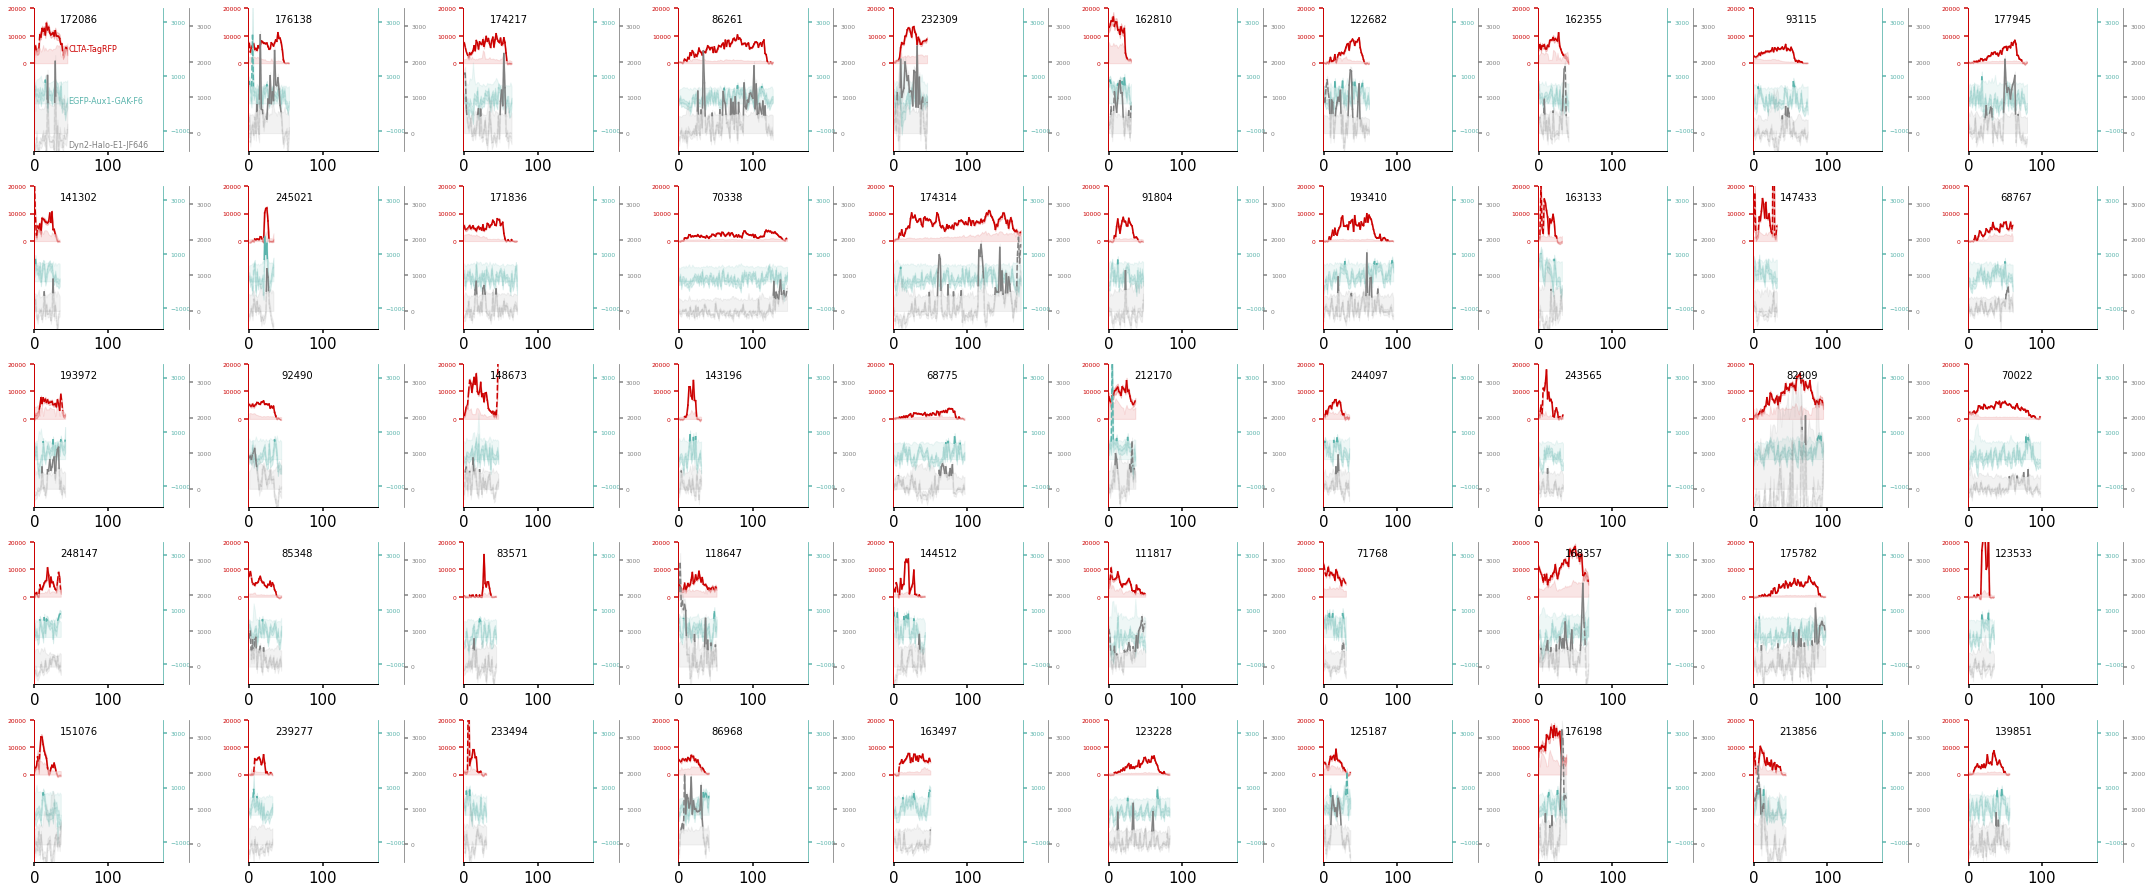

In [52]:
    R = 5
    C = 10
    MULT = R * C

    fig = plt.figure(figsize=(C * 3, R * 2.5), facecolor='w')
 

 
    clathmax = 16000
    auxmax = 3500
    
    viz.plot_curves(d.iloc[:50], R=R, C=C, hline=False,
                xlim_constant=True,
                ylim_constant=True,
                legend=True,
                extra_key='Z_extended',
                extra_key_label='Dynamin',
                #xlim=(0, 55),
                ylim_cla=(-500, clathmax),
                ylim_aux=(-500, auxmax),
                ylim_dyn=(-500, auxmax),
                yticks=[0, 2000],
                background=True,
                show_track_pid=True,
                #yticklabels=["$0$", "$10^4$"],                
                fig=fig
        )
    plt.savefig(f'fp_large.pdf')